#### Requirements

You can install the requirements for this notebook using pip (`pip install requests h5py lxml`). Then we can load in some libraries to do some data munging.

In [3]:
%matplotlib inline

import requests
import numpy
import shapely, shapely.geometry
import descartes
import h5py
import textwrap
import os
import hashlib
import matplotlib.pyplot as plt
from lxml import etree

#### Get capabilities and layers of Geology WFS for Western Australia

We'll pull URLs from http://www.ga.gov.au/data-pubs/web-services/ga-web-services

In [4]:
url = "http://www.ga.gov.au/geows/geologicunits/oneg_wa_1m/wfs"

Make a GetCapabilities request to the endpoint to see what layers are available

In [5]:
get_wfs_capabilities = {
    "service": "wfs",
    "request": "GetCapabilities"
}
response = requests.get(url, params=get_wfs_capabilities)
response.url

'http://www.ga.gov.au/geows/geologicunits/oneg_wa_1m/wfs?request=GetCapabilities&service=wfs'

In [6]:
if response.ok:
    capabilities = etree.fromstring(response.content)
capabilities

<Element {http://www.opengis.net/wfs}WFS_Capabilities at 0x7ffdc1d01988>

We're going to use XPath queries to find information about this WFS. Lxml's xpath module is great but fairly general. One of the neat things that it lets you do is define namespaces to save you typing things out, but you have to pass the namespace mapping to each XPath query. 

To make things a bit easier we'll define some namespaces used by GeoSciML/OGC to pass to the xpath method.

In [7]:
def _unwrap(query_result, unwrap=True):
    """ Unwrap a query result.
        
        Parameters:
            query_result - the query result from xpath
            unwrap - whether to unwrap or not
        
        Returns: 
            If there's only one match and unwrap=True, then the 
            etree.Element is returned directly, rather than in a 
            list. If there's no matches and unwrap=True, then the
            function returns None. 

            If unwrap=False, then this always returns a list.
    """
    # Exit straight away if we're not unwrapping
    if not unwrap:
        return query_result
    
    # Return based on length
    length = len(query_result)
    if length == 1:
        return query_result[0]
    elif length > 1:
        return query_result
    else:
        return None
        

def xpath(tree, query, unwrap=True):
    """ Perform a namespace-resolved XPath query on a given tree
    
        Parameters:
            tree - the lxml.etree instance to query
            query - the XPath query
            unwrap - whether to unwrap the result. If there's only
                one match and unwrap=True, then the etree.Element is returned
                directly, rather than in a list. If unwrap=False, then 
                this always returns a list.
        
        Returns:
            a list of matching elements from the tree. 
    """
    ns = dict(namespaces = {
        "ows": "http://www.opengis.net/ows",
        "ogc": "http://www.opengis.net/ogc",
        "wfs": "http://www.opengis.net/wfs",
        "wcs": "http://www.opengis.net/wcs",
        "gml": "http://www.opengis.net/gml",
        "gsml": "urn:cgi:xmlns:CGI:GeoSciML:2.0",
        "sa": "http://www.opengis.net/sampling/1.0",
        "xlink": "http://www.w3.org/1999/xlink",
        "xsi": "http://www.w3.org/2001/XMLSchema-instance"
    })
    return _unwrap(tree.xpath(query, **ns), unwrap=unwrap)

In [8]:
bounds = xpath(capabilities, '//ows:WGS84BoundingBox')[0]
print(etree.tostring(bounds, pretty_print=True))

b'<ows:WGS84BoundingBox xmlns:ows="http://www.opengis.net/ows" xmlns:ogc="http://www.opengis.net/ogc" xmlns:wfs="http://www.opengis.net/wfs" xmlns:gml="http://www.opengis.net/gml" xmlns:gsml="urn:cgi:xmlns:CGI:GeoSciML:2.0" xmlns:sa="http://www.opengis.net/sampling/1.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n\t\t\t\t<ows:LowerCorner>112.50 -35.50</ows:LowerCorner>\n\t\t\t\t<ows:UpperCorner>129.00 -13.50</ows:UpperCorner>\n\t\t\t</ows:WGS84BoundingBox>\n\t\t\n'


Then we can look for what features this service offers us

In [9]:
from collections import OrderedDict
feature_types = xpath(capabilities, "//wfs:FeatureType")

# Collate info about the feature types
feature_info = {}
for f in feature_types:
    finfo = OrderedDict()
    # Get basic info
    for tag in ('Name', 'Title', 'Abstract'):
        query = './wfs:{0}/text()'.format(tag)
        finfo[tag] = xpath(f, query)
    
    # Get bounding box
    for tag in ('LowerCorner', 'UpperCorner'):
        query = './/ows:WGS84BoundingBox/ows:{0}/text()'.format(tag)
        finfo[tag] = tuple(float(c) for c in xpath(f, query).split())
    
    feature_info[finfo['Name']] = finfo

In [10]:
for name, info in feature_info.items():
    print('\n{0}'.format(name))
    print('\n'.join(' -- {0}: {1}'.format(*it) for it in info.items()))


gsml:MappedFeature
 -- Name: gsml:MappedFeature
 -- Title: Mapped features
 -- Abstract: Polygon shapes depicting the distribution of surface geologic units in Western Australia, 1:1M scale
 -- LowerCorner: (112.5, -35.5)
 -- UpperCorner: (129.0, -13.5)

gsml:GeologicUnit
 -- Name: gsml:GeologicUnit
 -- Title: Geologic Unit
 -- Abstract: Descriptions of surface geologic units in Western Australia, 1:1M scale
 -- LowerCorner: (112.5, -35.5)
 -- UpperCorner: (129.0, -13.5)


GeoSciML publishes geological data in two sections. The first, `gsml:GeologicUnit` is the description of a particular unit, while the second, `gsml:MappedFeature` is the actual geospatial polygon. You can think of the `gsml:MappedFeature` features as being the map, and the `gsml:GeologicUnit` as being the key/legend which tells you what you're looking at.

For more on GeoSciML you can check out http://www.geosciml.org/, although that's much more focused on building a web service to serve GSML than actually using it (a typical blind spot for standards unfortunately).

Ok, so the next thing you can do with the WFS is get a description of the layers using a GetFeature request. The capabilities document tells you the url to do this:

In [11]:
query = './/ows:Operation[@name = "GetFeature"]//ows:Post/@xlink:href'
feature_url = xpath(capabilities, query)
feature_url

'http://www.ga.gov.au/geows/geologicunits/oneg_wa_1m/wfs'

The issue is that while the document tells you that the endpoint allows you to make requests using Get, Geoscience Austrlia doesn't yet have key-value ("restful") style queries implemented yet. This means that we have to send an XML documet to the endpoint which contains our query.

The following XML template describes an OGC GetFeature request which just asks for all mapped features inside some bounding box:

In [12]:
BBOX_FEATURE_REQUEST = textwrap.dedent("""\
    <?xml version="1.0" encoding="utf-8"?>
    <wfs:GetFeature
     xmlns:wfs="http://www.opengis.net/wfs"
     xmlns:ogc="http://www.opengis.net/ogc"
     xmlns:gml="http://www.opengis.net/gml"
     xmlns:sa="http://www.opengis.net/sampling/1.0"
     maxFeatures="{max_features}" service="WFS"
     version="1.1.0" xmlns:gsml="urn:cgi:xmlns:CGI:GeoSciML:2.0">
       <wfs:Query typeName="gsml:MappedFeature">
        <ogc:Filter xmlns:ogc="http://www.opengis.net/ogc">
           <ogc:BBOX>
             <ogc:PropertyName>gsml:shape</ogc:PropertyName>
             <gml:Envelope srsName="EPSG:4326">
               <gml:lowerCorner>
                 {lower_corner[0]}, {lower_corner[1]}
               </gml:lowerCorner>
               <gml:upperCorner>
                 {upper_corner[0]}, {upper_corner[1]}
               </gml:upperCorner>
             </gml:Envelope>
           </ogc:BBOX>
         </ogc:Filter>
       </wfs:Query>
    </wfs:GetFeature>
""")

And then we can make a function to post the requests to the WFS. One other slight issue is that GA doesn't implement paging automatically, so you'll just end up timing out if you ask for too large an area. We handle this by allowing you to split the bounding box into a series of sub blocks which are processed individually.

In [13]:
def get_linestring(elem, unwrap=True):
    """ Convert element text to numpy array
    """
    poslists = []
    for poslist in xpath(elem, './/gml:posList', unwrap=False):
        poslist = numpy.fromstring(poslist.text, sep=' ')
        poslists.append(poslist.reshape(len(poslist) // 2, 2))
    return _unwrap(poslists, unwrap=unwrap)

def get_polygons(elem, unwrap=True):
    """ Get all the polygons from some element
    
        Parameters:
            elem - the element to unwrap the polygons from
            unwrap - whether to unwrap the result. If there's only
                one match and unwrap=True, then the etree.Element is returned
                directly, rather than in a list. If unwrap=False, then 
                this always returns a list.
        
        Returns:
            a list of `Shapely.geometry.Polygon` objects and their hashes
    """
    polygons = []
    for polygon in xpath(elem, './/gml:Polygon', unwrap=False):
        # Extract the outer path, which we hash down to use as a shape ID
        outer = get_linestring(xpath(polygon, './gml:outerBoundaryIs'))
        inners = xpath(polygon, './gml:innerBoundaryIs', unwrap=False)
        inners = [get_linestring(e) for e in inners]
        polygons.append(shapely.geometry.Polygon(shell=outer, holes=inners))
    return _unwrap(polygons, unwrap=unwrap)

def get_feature_polygons(features, unwrap=True):
    """ Extract a list of polygons from some features
    """
    result = [get_polygons(xpath(f, './gsml:shape')) for f in features]
    return _unwrap(result, unwrap=unwrap)
                   
def get_feature_specifications(features):
    """ Extract some basic information from an element containing one or 
        more gsml:specifications elements
    
        Parameters:
            features - the element to extract the specification from
        
        Returns:
            feature_ids, specification_ids, metadata - a tuple with the first
                two items being lists of features and specification IDs, sorted 
                by order in the document, and the third s mapping from 
                specification ID to a dictionary of metadata
    """
    # Specify what we want to extract
    to_get = [
        ('description', 'gml:description'),
        ('compositionCategory', 'gsml:compositionCategory//gsml:value'),
        ('strat_name', 'gml:name[@codeSpace="urn:cgi:classifierScheme:GA:StratigraphicLexicon:Stratname"]'),
        ('strat_id', 'gml:name[@codeSpace="urn:cgi:classifierScheme:GA:StratigraphicLexicon:Stratno"]'), 
        ('map_symbol', 'gml:name[@codeSpace="urn:cgi:classifierScheme:GA:StratigraphicLexicon:Map_symbol"]')
    ]

    # We will accumulate a dictionary of metadata, and a list of ids for each element
    metadata, spec_ids, feature_ids = {}, [], []
    for feat in features:
        spec = xpath(feat, './gsml:specification')
        fid = feat.attrib.get('{http://www.opengis.net/gml}id')
        feature_ids.append(fid)
        sid = spec.attrib.get('{http://www.w3.org/1999/xlink}href')
        nchildren = len(spec.getchildren())
        if nchildren == 0 and sid:  # We already have this data somewhere
            spec_ids.append(sid.split('_')[-1])
        elif nchildren == 1:  # This is the first time seeing this unit
            _info = \
                {k: xpath(spec, './gsml:GeologicUnit/' + q).text
                 for k, q in to_get}
            sid = _info['strat_id']
            metadata[sid] = _info
            spec_ids.append(sid)

        else:  # Something's gone wrong!
            raise ValueError('Element {0} has no links to a gsml:specification')
    
    return feature_ids, spec_ids, metadata

def post_block_requests(wfsurl, lower_left, upper_right, nx_blocks, 
                        ny_blocks=None, max_features=500, timeout=2000,
                        filename='features', force_update=False):
    """ Make several POST requests to a WFS URL and stash the data in seperate
        XML files

        This method splits a large bounding box into several smaller boxes and
        makes a request for each box seperately. This is useful for Web Feature
        Services which do not implement paging support.
        
        Parameters:
            wfsurl - The URL of the Web Feature Service to query
            lower_left, upper_right - A (latitude, longitude) tuple
                denoting the lower/upper corners of the bounding box
            nx_blocks, ny_blocks - The number of subblocks in each direction.
                ny_blocks is optional - if set to None or not specified it takes
                the same value as nx_blocks.
            max_features - The maximum number of features to ask for from the
                server. If you find that you're missing some features, try
                increasing this value. Alternatively, if you're getting a lot of
                timeout errors (503s) then try decreasing this value and
                increasing the number of subblocks in the query.
            timeout - The timeout for each request, in seconds.
            filename - The root filename to stream the response to. The
                individual requests will be split into individual files,
                with each subfilename looking like {filename}_{index}.xml.
            force_update - if True, downloads all files again from server, 
                otherwise just uses cached files
    """
    ## Split bounding box into blocks to make requests more manageable
    # Work out block sizes
    if ny_blocks is None:
        ny_blocks = nx_blocks
    (lx, ly), (ux, uy) = lower_left, upper_right
    dx = (ux - lx) / float(nx_blocks)
    dy = (uy - ly) / float(ny_blocks)

    # Return blocks as lower and upper corners
    x_idx, y_idx = \
        numpy.meshgrid(numpy.arange(nx_blocks), numpy.arange(ny_blocks))    
    lower_x, upper_x = [lx + x * dx for x in (x_idx, x_idx + 1)]
    lower_y, upper_y = [ly + y * dy for y in (y_idx, y_idx + 1)]
    blocks = list(zip(zip(lower_x.ravel(), lower_y.ravel()),
                  zip(upper_x.ravel(), upper_y.ravel())))

    ## Iterate over blocks, make requests
    idents, shapes, metadata = [], [], {}
    fid_cache = set()
    for block_idx, (lower_left, upper_right) in enumerate(blocks):
        # Get temporary file ID, download data if required
        tmpfile = '{0}_{1}.xml'.format(filename, block_idx)
        if force_update or not os.path.isfile(tmpfile):
            params = dict(lower_corner=lower_left,
                          upper_corner=upper_right,
                          max_features=max_features)
            response = requests.post(url=wfsurl,
                                     data=BBOX_FEATURE_REQUEST.format(**params),
                                     stream=True,
                                     timeout=timeout)
            if response.ok:
                with open(tmpfile, 'wb') as fhandle:
                    for chunk in response.iter_content(chunk_size=int(1e5)):
                        fhandle.write(chunk)
        
        # Now we definitely have the data on disk, so parse it and add to stuff
        features = xpath(etree.parse(tmpfile), '//gsml:MappedFeature')
        fids, sids, meta = get_feature_specifications(features)
        shps = get_feature_polygons(features)
        
        # We need to make sure that we're not adding a shape from previously
        # We store the bounding box and the ident in a set
        for fid, sid, shape in zip(fids, sids, shps):
            if fid in fid_cache:
                # We already have this shape
                continue
            else:
                idents.append(sid)
                shapes.append(shape)
                fid_cache.add(fid)
        metadata.update(meta)
    return idents, shapes, metadata

And we can try this out:

In [14]:
feature_info['gsml:MappedFeature']['LowerCorner']

(112.5, -35.5)

Select the corners we're going to plot

In [15]:
lower_left = (120, -30)
upper_right = (121, -29)

bbox = list(lower_left) + list(upper_right)
bbox = shapely.geometry.box(*bbox)

In [16]:
idents, shapes, metadata = \
    post_block_requests(wfsurl=feature_url, 
                        filename='tmp', 
                        lower_left=lower_left, 
                        upper_right=upper_right,
                        nx_blocks=3, max_features=300)

In [21]:
[(it['map_symbol'], it['description']) for it in metadata.values()]

[('Qrc',
  'Colluvium and/or residual deposits, sheetwash, talus, scree; boulder, gravel, sand; may include minor alluvial or sand plain deposits, local calcrete and reworked laterite'),
 ('Asy',
  'Conglomerate, chert, small amounts felsic volcaniclastic rocks, sandstone, quartzite, siltstone, phyllite, schist, pelite, shale.  Includes the former Hatfield Formation.'),
 ('Agjo', 'Equigranular monzogranite.'),
 ('Adef',
  'Coarse-grained gabbro with clinopyroxene olkocrysts; metamorphosed.'),
 ('Ady',
  'Mafic intrusive rocks, medium to coarse-grained; layered mafic to ultramafic intrusions; metadolerite; medium to coarse-grained metagabbro, dolerite and granophyre, local ultramafic bases'),
 ('Anh',
  'Banded to agmatitic felsic and/or granitic gneiss, migmatite; high-Ca group.'),
 ('Agh',
  'Monzogranite, granodiorite, tonalite, quartz monzonite; in places recrystallised and foliated; some mixed granite and country rock assemblages; high-Ca granite'),
 ('Czl',
  'Ferruginous duricrus

In [22]:
groupings = {
    'archean_mafic': ['Abe', 'Aby','Ade', 'Adef', 'Ady', 'Aey'],
    'archean_felsic': ['Afe', 'Ag', 'Agh', 'Aghcf', 'Aghgg', 'Agjo', 'Agl', 
                       'Agla', 'Aglcf', 'Aglcw', 'Agmys', 'Agh', 'Auy'],
    'archean_other': ['Awy', 'Acy', 'Aee', 'Anf', 'Anh', 'Asy', 'Aty', 'Aue'],
    'cenozoic_laterite': ['Czl', 'Czz'],
    'cenozoic_seds': ['Czs'],
    'quaternary': ['Qa', 'Qd', 'Qdlu', 'Qrc', 'Qt']
}

reverse_groupings = {}
for group, keys in groupings.items():
    for key in keys:
        reverse_groupings[key] = group
        
get_group = lambda k: reverse_groupings[k]

(-30, -29)

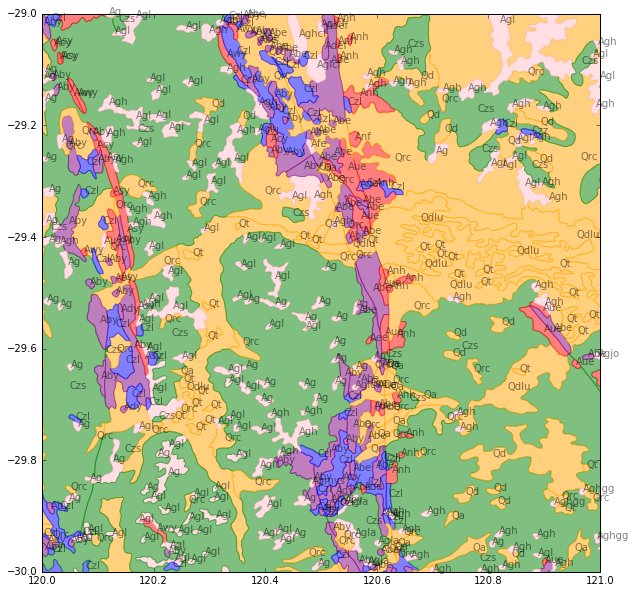

In [24]:
# Color by first letter of map symbol (which gives age)
colors = {
    'archean_mafic': 'purple',
    'archean_felsic': 'pink',
    'archean_other': 'red',
    'cenozoic_laterite': 'blue',
    'cenozoic_seds': 'green',
    'quaternary': 'orange'
}

# Make plot of data
f, ax = plt.subplots(1, 1)
f.set_size_inches(10, 10)
for shape, ident in zip(shapes, idents):
    symbol = metadata[ident]['map_symbol']
    group = get_group(symbol)
    color = colors[group]
    ax.add_patch(descartes.PolygonPatch(shape, fc=color, ec=color, alpha=0.5))
    
    # Add a label if it's going to be inside the axes
    rpoint = shape.representative_point()
    if bbox.contains(rpoint):
        x, y = rpoint.xy
        ax.text(x[0], y[0], symbol, alpha=0.5)
ax.set_xlim(lower_left[0], upper_right[0])
ax.set_ylim(lower_left[1], upper_right[1])